In [1]:
import pandas as pd
import pandas_datareader.data as web
from pandas.tseries.offsets import BDay
import datetime
import warnings
from copy import deepcopy
import numpy as np
%matplotlib inline
from scipy.stats import linregress
import matplotlib.pyplot as plt
from math import sqrt
import scipy.stats as st
import pyfolio as pf
from __future__ import division
import cvxopt as opt
from cvxopt import matrix
from cvxopt.blas import dot
from cvxopt.solvers import qp, options

In [2]:
def asset_alloc(time,code_list, alpha):
    n = len(code_list)
    returns = []
    print code_list
    for code in code_list:
        stock_val = web.DataReader(code, 'yahoo', start = '1/1/2005', end = time)
        stock_val = stock_val['Adj Close']
        monthly = stock_val.resample('BM', how=lambda x: x[-1])
        ress = monthly.pct_change()
        ress = ress.dropna()
        arr = []
        for index, x in ress.iteritems():
            arr.append(x)
        returns.append(arr)
        
    #print returns
    Mu = np.mean(returns, axis=1)
    Cov = np.cov(returns)
    mean = []
    var= []
    for i in range(10000):
        w = abs(np.random.randn(n))
        w = w / np.sum(w)
        mean.append(np.dot(Mu, w.T))
        var.append( sqrt(np.dot(np.dot(w,Cov),w.T))  )

    P = matrix(Cov)
    q = matrix(0.0, (n,1))

    G = matrix(np.concatenate([-np.eye(n,n), -np.reshape(Mu.T, (1,n))]))

    h = np.zeros(n+1)
    h[-1] = -alpha
    h = matrix(h)

    A = matrix(1.0, (1,n))
    b = matrix(1.0)
    options['show_progress'] = True
    options['solver'] = 'mosek'
    #print  P, q, G, h, A ,b
    solution = qp(P, q, G, h, A, b)['x'] 
    return solution


In [3]:
symbols = ['GOOGL', 'IBM', 'AAPL', 'SPY']

start = datetime.datetime(2010,1,1)
end = datetime.datetime.now()

In [4]:
prices = pd.DataFrame()
for symbol in symbols:
    f = web.DataReader(symbol, 'yahoo', start, end)
    f['symbol'] = symbol
    prices = pd.concat([prices, f])
    #print symbol
prices;

In [5]:
prices = prices.pivot(columns="symbol", values="Adj Close")

In [6]:
dividends_and_splits= pd.DataFrame()

for symbol in symbols:
    f = web.DataReader(symbol, 'yahoo-actions')
    if len(f) > 0:
        f['symbol'] = symbol
        dividends_and_splits = pd.concat([dividends_and_splits, f])

In [7]:
# TODO: check user account's free cash and update it accordingly
def execute_order(order, holdings):
    'Simulates the broker/market and creates a transaction.'
    transaction = deepcopy(order)
    symbol, shares, time = order['symbol'], order['shares'], order['time']
    
    if order['action']=='sell':
        if (holdings is None or  
            not (symbol in holdings.index) or 
            holdings.loc[symbol]['shares'] < order['shares']):
            
            warnings.warn('Your order ' + str(order) + ' is rejected.')
            transaction['status'] = 'rejected'
            return transaction
    
    transaction['status'] = 'accepted'
    price = get_price(symbol, time)
    commision = commision_calculation(order, price)
    transaction['price'], transaction['commision'] = price, commision
    return transaction

def get_price(symbol, time = None, price_source=prices):
    'Returns the last price of the symbol. We assume that prices is a pandas object.'
    if time is None:
        time = str(datetime.datetime.now())
    
    try: 
        closest_time = (price_source.index[time >= price_source.index]).sort_values()[-1]
        return price_source[symbol].loc[closest_time]
    except ValueError:
        raise ValueError("We don't have historical data for an order at " + order_time)
    except IndexError:
        raise IndexError("We don't have historical data for an order at " + order_time)

def commision_calculation(order, price, commission_ratio=0.0001):
    'Calculates commision to be paid.'
    return order['shares']*price*commission_ratio

def current_time(prices=prices):
    'Returns the maximum date from the prices table.'
    return max(prices.index).strftime("%Y-%m-%d")

In [8]:
def apply_transaction(transaction, positions, trades):
    'Update positions and trades with the transaction.'
    if transaction["status"] == "accepted":
        symbol, action, shares = transaction["symbol"], transaction["action"], transaction["shares"]
        price, time = transaction["price"], transaction['time']
        if action == "buy":
            position = {'type':'long', 
                        'symbol':symbol, 
                        'initial_shares':shares, 
                        'shares':shares, 
                        'price': price, 
                        'cost': price*shares, 
                        'time': time}
            positions.append(position)
        else:
            match_sell_transaction_to_position(transaction, positions, trades)

def match_sell_transaction_to_position(transaction, positions, trades):
    """We will select the positions with the same symbol and order them according to time desc.
    Until we finish the order's volume we match it with a position. If a position is fulfilled,
    we continue with the next one in the order. We create a trade, we remove the amount traded 
    from the position. If the position's volume is empty we remove the position from the list.
    
    Assumption: Since the broker rejects sells orders greater then our holdings, 
    we assume that transaction.shares <= sum(positions.shares)."""
    
    sorted(positions, key=lambda k: k['time']) 
    shares, time, symbol = transaction["shares"], transaction["time"], transaction["symbol"]
    
    for position in positions:
        if not shares > 0:
            break
        if position["symbol"] == transaction["symbol"] and position["shares"] > 0:
            traded_shares = min(shares, position['shares'])
            buy_price, sell_price = position["price"], transaction["price"]
            profit = (sell_price - buy_price) * traded_shares
            trade = {'symbol':symbol, 
                     'shares':traded_shares, 
                     'time':time, 
                     'buy_price': buy_price, 
                     'sell_price': sell_price, 
                     'profit': profit}
            trades.append(trade)
            shares -= traded_shares
            position["shares"] = position["shares"] - traded_shares
            position["cost"] = position["shares"] * buy_price

In [9]:
def calculate_portfolio(positions):
    if len(positions) == 0:
        return []
    else:
        temp = pd.DataFrame(positions)
        return temp.pivot_table(index='symbol', aggfunc='sum', values=["cost", 'shares'])

In [10]:
def execute_orders(orders, transactions, positions, trades):
    """Calls execute_order function for each order in the order list.
    Updates transaction, position and trade lists.
    """
    
    portfolio = calculate_portfolio(positions)
    for order in orders:
        transaction = execute_order(order, portfolio)
        transactions.append(transaction)
        apply_transaction(transaction, positions, trades)
        portfolio = calculate_portfolio(positions)

In [11]:
def get_prices(assets, time = None):
    return {symbol: get_price(symbol, time) for symbol in assets}

#pd.Series(get_prices(portfolio.index))

In [12]:
def current_performance(portfolio, time=None):
    portfolio["current_price"] = pd.Series(get_prices(portfolio.index, time))
    portfolio["market_value"] = portfolio["shares"] * portfolio["current_price"]
    portfolio["profit"] = portfolio["market_value"] - portfolio["cost"]
    
    total_market_value = portfolio.market_value.sum()
    portfolio["weight"] = portfolio["market_value"] / total_market_value

In [13]:
def historical_performance(transactions, prices):
    "Returns historical market value of a portfolio."
    starting_date = min(transactions, key=lambda x: x["time"])["time"]
    ending_date = datetime.datetime.now()
    symbols = set([t["symbol"] for t in transactions if t["status"]=="accepted"] )
    
    symbol_price = (prices.loc[starting_date:ending_date][list(symbols)])
    
    holdings_list = holdings(transactions)
    
    return (holdings_list
            .fillna(method='ffill')
            .reindex(symbol_price.index.union(holdings_list.index))
            .fillna(method='ffill')
            .reindex(symbol_price.index)
            .mul(symbol_price).sum(axis=1)
           )

def holdings(transactions):
    t = pd.DataFrame(transactions)
    t["sign"] = t["action"].apply(lambda x: 1 if x=="buy" else -1)
    t["signed_shares"] = t["sign"] * t["shares"]
    t["time"] = pd.to_datetime(t["time"])
    
    return (t.query("status == 'accepted'")
     .pivot_table(values="signed_shares", columns="symbol", index="time")
     .cumsum()
    )

In [14]:
def compare_with_benchmark(historical_value, benchmark_symbol="XU100.IS"):
    algo = (historical_value[historical_value > 0].pct_change() + 1).cumprod()
    algo.name = "Algorithm"
    algo.plot(legend=True)
    print "Algorithm performance:", (algo.ix[-1] - 1)*100
    
    start_date = historical_value.index[0]

    benchmark = (prices[benchmark_symbol].dropna().pct_change().loc[start_date:] + 1).cumprod()
    benchmark.name = "Benchmark"
    benchmark.plot(legend = True, figsize=[15,10])
    print "Benchmark performance:", (benchmark.ix[-1] - 1)*100

In [15]:
def paid_dividends(transactions, dividends):
    
    start_date = min(transactions, key=lambda x: x["time"])["time"]
    end_date = datetime.datetime.now()
    
    H= holdings(transactions)
    H.index = pd.to_datetime(H.index)
    
    H = (H.reindex(pd.date_range(start=start_date, end=end_date, freq='D'))
         .fillna(method='ffill')
         .fillna(0))
    
    return (pd.melt(Dividends[Dividends.symbol.apply(lambda x: x in H.columns)]
                    .reset_index()
                    .rename(columns={'index':'time'})
                    .pivot_table(values="value", columns="symbol", index = 'time')
                    .reindex(H.index)
                    .mul(H)
                    .reset_index()
                    .rename(columns={'index':'time'})
                    , id_vars = 'time', var_name= 'symbol', value_name='paid_dividend'
                    )
            ).query("paid_dividend > 0")

In [16]:
def rebalance(portfolio, target_weights, target_value = None, time = None):
    """New weights is a dictionary of {symbol: weights}.
    Creates orders to make portfolio's weight 'new weights'.
    Time indicates execution of rebalance operation.
    """
    if time is None:
        time = current_time()
    
    if target_value is None: 
        target_value = portfolio.market_value.sum()
        
    if len(portfolio)>0:
        target_weights = {s:target_weights[s] if s in target_weights.keys() else 0 
                          for s in set(portfolio.index | target_weights.keys())}
    print target_weights
    
    # check if the weights sum up to 1.
    #assert(sum(target_weights.values()) == 1)
        
    rebalance_orders = []
    
    target_market_value = {s:target_weights[s]*target_value for s in target_weights.keys()}
    
    for symbol, weight in target_weights.iteritems():
        
        if len(portfolio)>0 and symbol in portfolio.index:
            delta_value = target_market_value[symbol] - portfolio["market_value"].loc[symbol]
            
            if weight:
                delta_lot = int(abs(delta_value / get_price(symbol, time)))
            else:
                delta_lot = portfolio["shares"].loc[symbol]
            
            if delta_lot:
                if delta_value > 0:
                    action = 'buy'
                else:
                    action = 'sell'
            
                order = {'symbol': symbol, 'shares': delta_lot, 'action': action, 'time': time}
                rebalance_orders.append(order)
        else:
            delta_lot = int(target_market_value[symbol] / get_price(symbol, time))
            order = {'symbol': symbol, 'shares': delta_lot, 'action': 'buy', 'time': time}
            rebalance_orders.append(order) 
    
    return rebalance_orders

# BACKTEST

In [17]:
capital_base = 100000
start, end = np.datetime64('2010-01-20 00:00:00'), datetime.datetime.now()
running_points = [date for date in prices.index if start <= date <= end]

In [18]:
def beta(price_data, start, end):
    returns = (prices.loc[start:end]
               #.resample('3BMS', 'first')
               .pct_change()
               .dropna())
    
    beta_values = {symbol: linregress(returns["SPY"], returns[symbol])[0] 
                   for symbol in price_data.columns if symbol != 'SPY'}
    return beta_values

In [34]:
portfolio, transactions, positions, trades = [], [], [], []

for t in running_points:
    time = t.strftime("%Y-%m-%d")
    
    if t in pd.date_range(start=running_points[0], periods=12, freq='BM'):
        #print t
        #print '-'*20
        code_l = []
        beta_values = beta(prices, prices.index[0], t)
        for s in sorted(beta_values, key=beta_values.get, reverse=True):
            #print s, beta_values[s]
            code_l.append(s)
            
        n = len(code_l)  
        
        ##Function for new weights
        foo = asset_alloc(t, code_l, 0.020)
        print sum(foo)
        #print code_l
        #print foo
        new_weights = dict(zip(code_l, foo))
        ###new_weights = {s: 1./n for s in sorted(beta_values, key=beta_values.get, reverse=True)[:n]}
        #print new_weights
        #new_weights = asset_alloc(t, code_l, 0.025) okey this works but format..
        #Calculations here...
        
        #print new_weights
        
        target_value = None if len(portfolio) else capital_base
        
        if len(portfolio) > 0:
            current_performance(portfolio, time)
        
        rebalance_orders = rebalance(portfolio, new_weights, target_value, time)
        
        #print "Before Orders"
        #print "-"*20
       #print portfolio
        #print " "
        
        #print "Orders"
        #print "-"*20
        #print pd.DataFrame(rebalance_orders)
        #print " "
        execute_orders(rebalance_orders, transactions, positions, trades)
        portfolio = calculate_portfolio(positions)
        current_performance(portfolio, time)
        
        #print "After Orders"
        #print "-"*20 
        #print portfolio
        #print " "
        
portfolio = calculate_portfolio(positions)

['AAPL', 'IBM', 'GOOGL']


/Users/unstblecrsr/Documents/miksinvest/venv/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)


     pcost       dcost       gap    pres   dres
 0:  2.9475e-03 -1.0020e+00  1e+00  6e-17  2e+00
 1:  2.9390e-03 -9.7853e-03  1e-02  1e-16  3e-02
 2:  2.6616e-03 -2.4159e-03  5e-03  1e-16  1e-02
 3:  3.6082e-03  2.6774e-04  3e-03  3e-16  5e-03
 4:  2.9547e-03  2.4401e-03  5e-04  8e-17  5e-04
 5:  2.6412e-03  2.6195e-03  2e-05  8e-17  2e-18
 6:  2.6322e-03  2.6320e-03  2e-07  1e-16  1e-18
 7:  2.6321e-03  2.6321e-03  2e-09  6e-17  4e-19
Optimal solution found.
1.0
{'AAPL': 0.33102248838334014, 'IBM': 0.4381835807133871, 'GOOGL': 0.23079393090327277}
['AAPL', 'IBM', 'GOOGL']
     pcost       dcost       gap    pres   dres
 0:  2.8999e-03 -1.0023e+00  1e+00  2e-16  2e+00
 1:  2.8917e-03 -9.8258e-03  1e-02  1e-16  3e-02
 2:  2.5767e-03 -1.6606e-03  4e-03  1e-16  1e-02
 3:  3.5491e-03  4.0522e-04  3e-03  1e-16  4e-03
 4:  2.8313e-03  2.3560e-03  5e-04  8e-17  4e-04
 5:  2.5459e-03  2.5265e-03  2e-05  1e-16  9e-19
 6:  2.5379e-03  2.5377e-03  2e-07  1e-16  2e-18
 7:  2.5378e-03  2.5378e-03  

In [35]:
current_performance(portfolio, time = '2016-08-04')

Algorithm performance: 195.786256836
Benchmark performance: 149.493786886


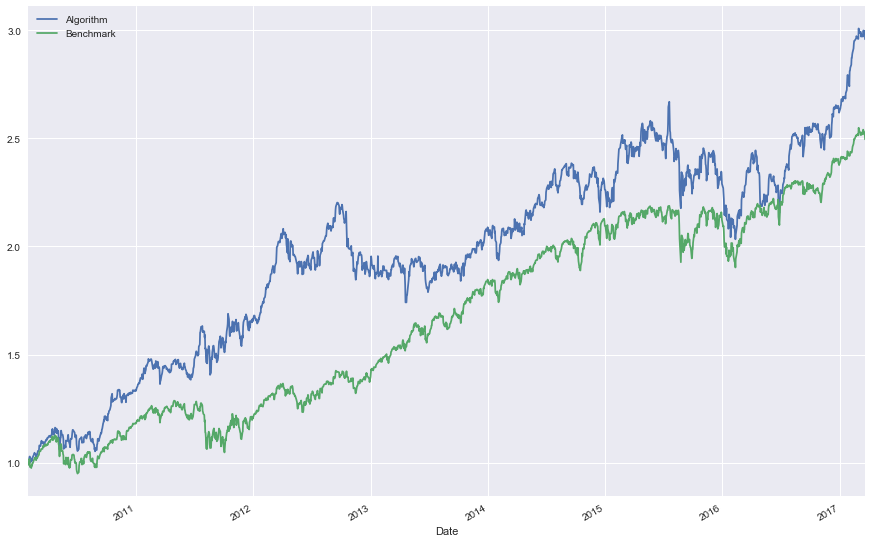

In [36]:
temp = historical_performance(transactions, prices)
compare_with_benchmark(temp, 'SPY')

In [37]:
temp = temp.pct_change()
temp = temp.tz_localize('utc')

Entire data start date: 2010-01-29
Entire data end date: 2017-03-21


Backtest Months: 85


Performance statistics,Backtest
annual_return,0.16
cum_returns_final,1.96
annual_volatility,0.18
sharpe_ratio,0.95
calmar_ratio,0.69
stability_of_timeseries,0.85
max_drawdown,-0.24
omega_ratio,1.18
sortino_ratio,1.38
skew,nan


Worst drawdown periods,net drawdown in %,peak date,valley date,recovery date,duration
0,23.83,2015-07-20,2016-02-11,2017-01-06,385
1,20.94,2012-09-18,2013-04-19,2014-06-04,447
2,13.85,2011-07-26,2011-08-19,2011-10-13,58
3,10.14,2012-04-03,2012-06-01,2012-08-17,99
4,9.47,2014-09-18,2014-12-16,2015-02-11,105




[-0.022 -0.047]


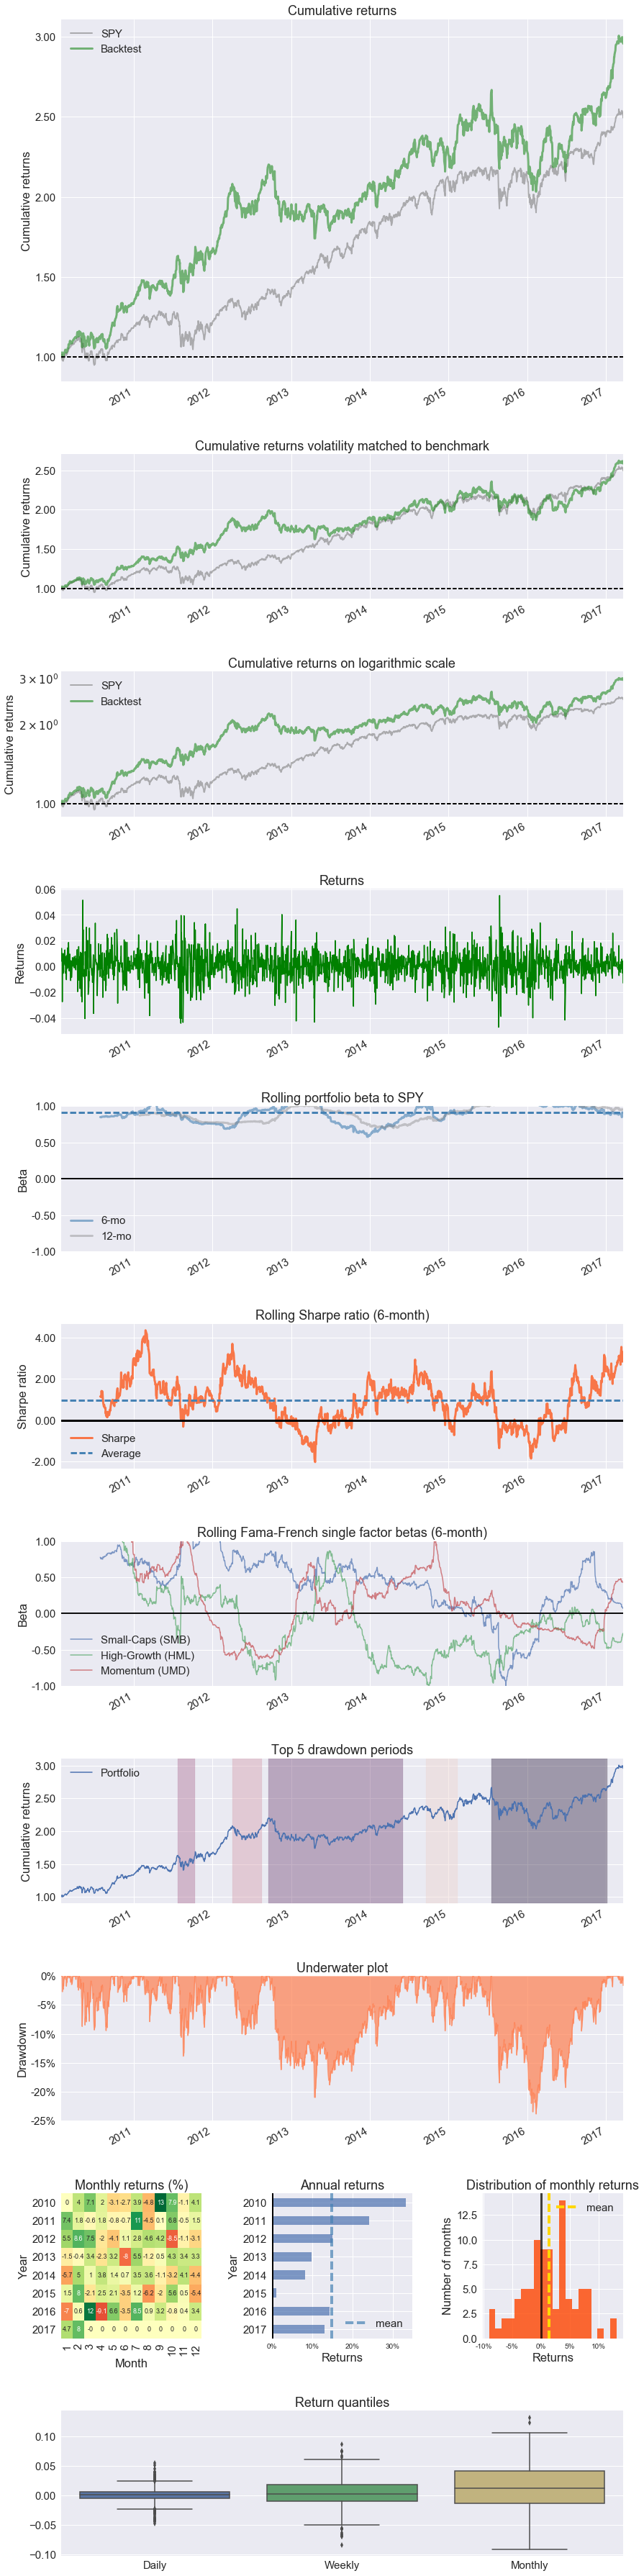

In [38]:
pf.create_returns_tear_sheet(temp)